# Combining supervised, unsupervised, and self supervised learning

## Introduction

During the course we have seen that supervised, unsupervised and self supervised has their pros and cons, and during the last lecture, we have seen that one of the problems of NN is noise, and we have used Unsupervised learning how to eliminate this problem.
To sum up then:
 - Supervised has the pro to be "direct" and easier, but labeling data it's expensive
 - Unsupervised has the pro to be cheap, but the best we can do is clustering and learning latent factors(and under this concept, there is also the solution for the denoising)

However, we have never tried to use self-supervised. Personally, I find it very interesting, because it has pros of both the models:
 - has a target value, and so can learn specific task
 - does not need the data to be labeled
As cons, it does not have too many applications, since to train it, most often, the target is either the data itself, or some transformation of it

Let's now project this reasoning on neural networks.  
The problem with Neural Networks is that to help us classify (example) some elements, the more features we have, the simplest is to find a classifier that performs decently.  
For example, even a simple Perceptron or Logistic regressor, having a linear decision boundary, benefits from more features, since the more dimension we have, the easiest is to linearly separate the data (usually).  
The drawback, is that the density of the data in the space where it's located, is inversely proportional to the dimensions of that space: this means that the more feature we have, the sparser the data is.

From a cognitive prospective, we can't solve this problem with algorithms, because I can hardly think that evolution allowed our brain to develop PCA as we know it, but there must be something that enables our brain to reduce the complexity/dimensionality of the informations that it receives, in some "natural" way.

To do so, we will use self-supervised learning. In particular, we will exploit the fact that we can enforce the number of neurons of our neural network to a specific number, and so we can "try to enforce" the NN to come from $N$ dimensional space to $N/2$ dimensions (for example), and so reducing the problem complexity and decrease the dimensionality.

However, to teach this in a supervised way, we should have also the data transformed in this new smaller space.  
To avoid this problem, we will try to teach the NN to also reconstruct the image from that smaller space, and so the target will be the input data itself.

In other words, we will use auto-encoders to try to "eliminate" some of the complexity of the problem.

Then we will see if this tool helps our NN to classify the test set, and possibly to ignore/remove the noise.

To do so, we will try 2 versions:
 1. Self-supervised $\rightarrow$ Supervised
 2. Self-supervised $\rightarrow$ Unsupervised $\rightarrow$ Supervised

This because, if the self supervised part is able to reduce the noise, and the unsupervised is able to extract latent features form the reconstructed image (that since it's been reconstructed from less dimensionality, should become less sensitive to noise), the final perceptron should be almost immune (in case of "small noise" to the noise itself), and so, as demostrated in the laboratory, be almost as powerful as a FeedForward neural network

So here it is the final models:
 - AutoEncoder + DBN + Perceptron (trained in one-vs-all):
   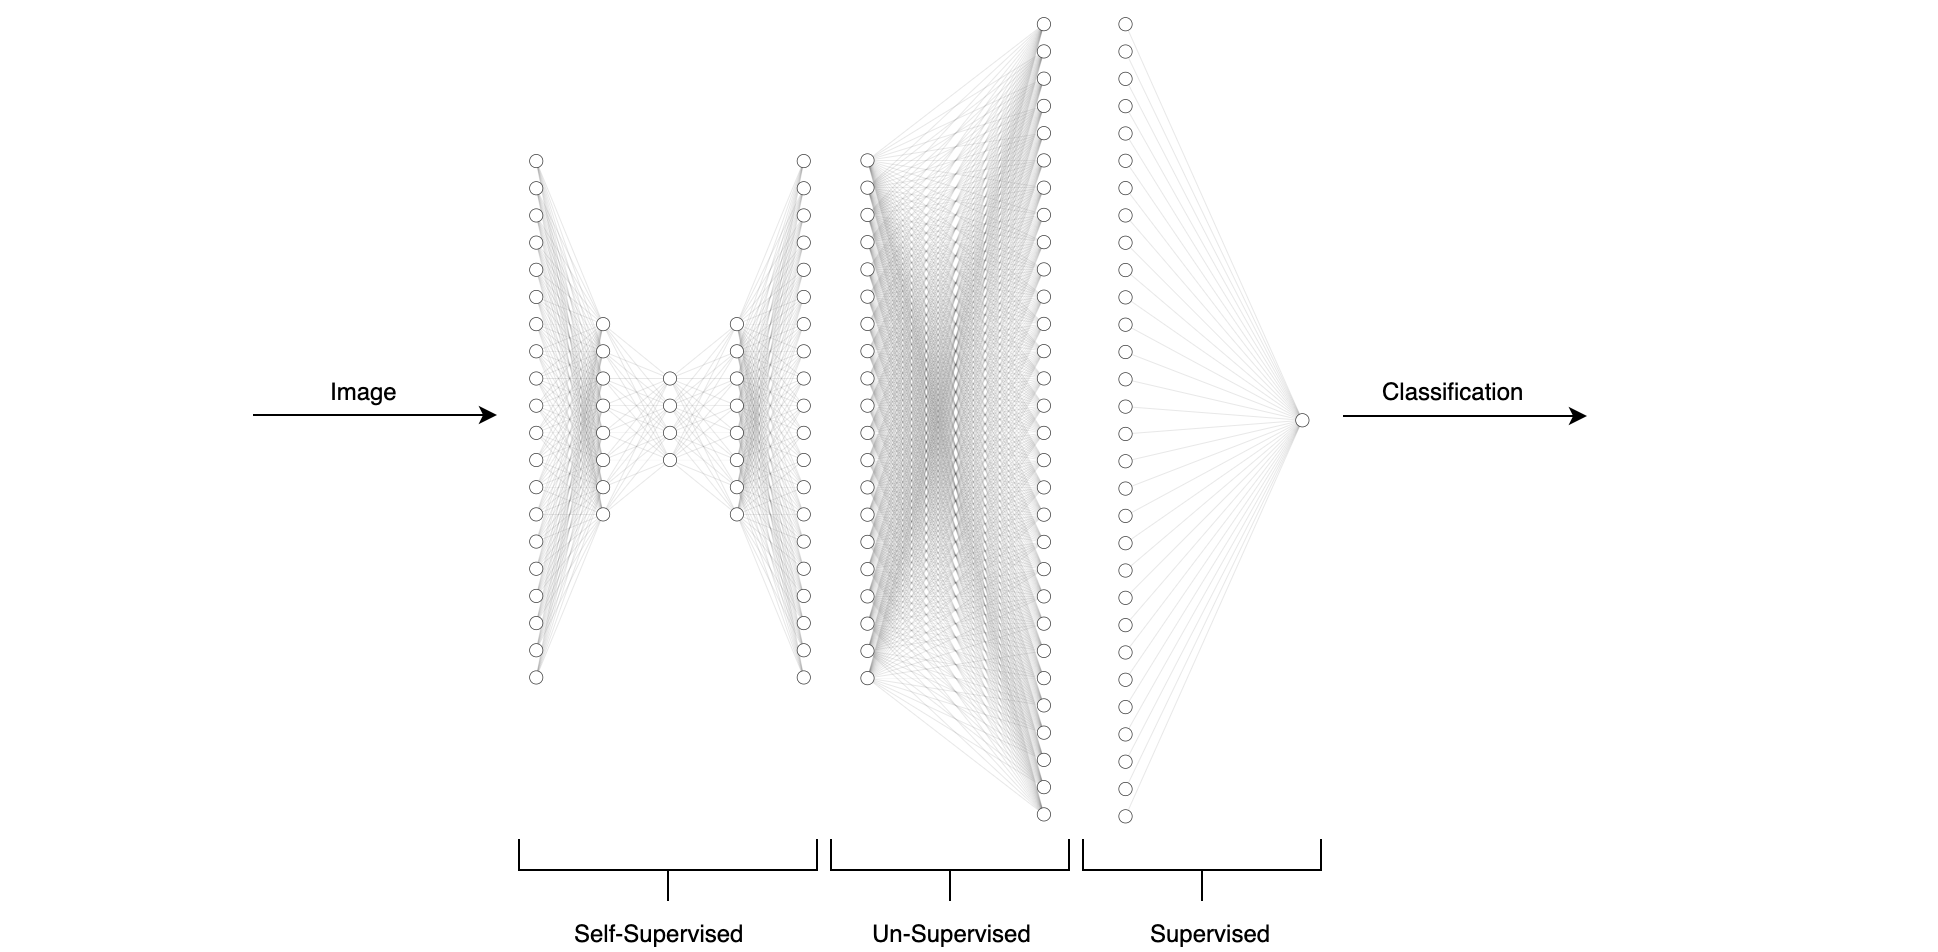
 - AutoEcnoder + NN:
   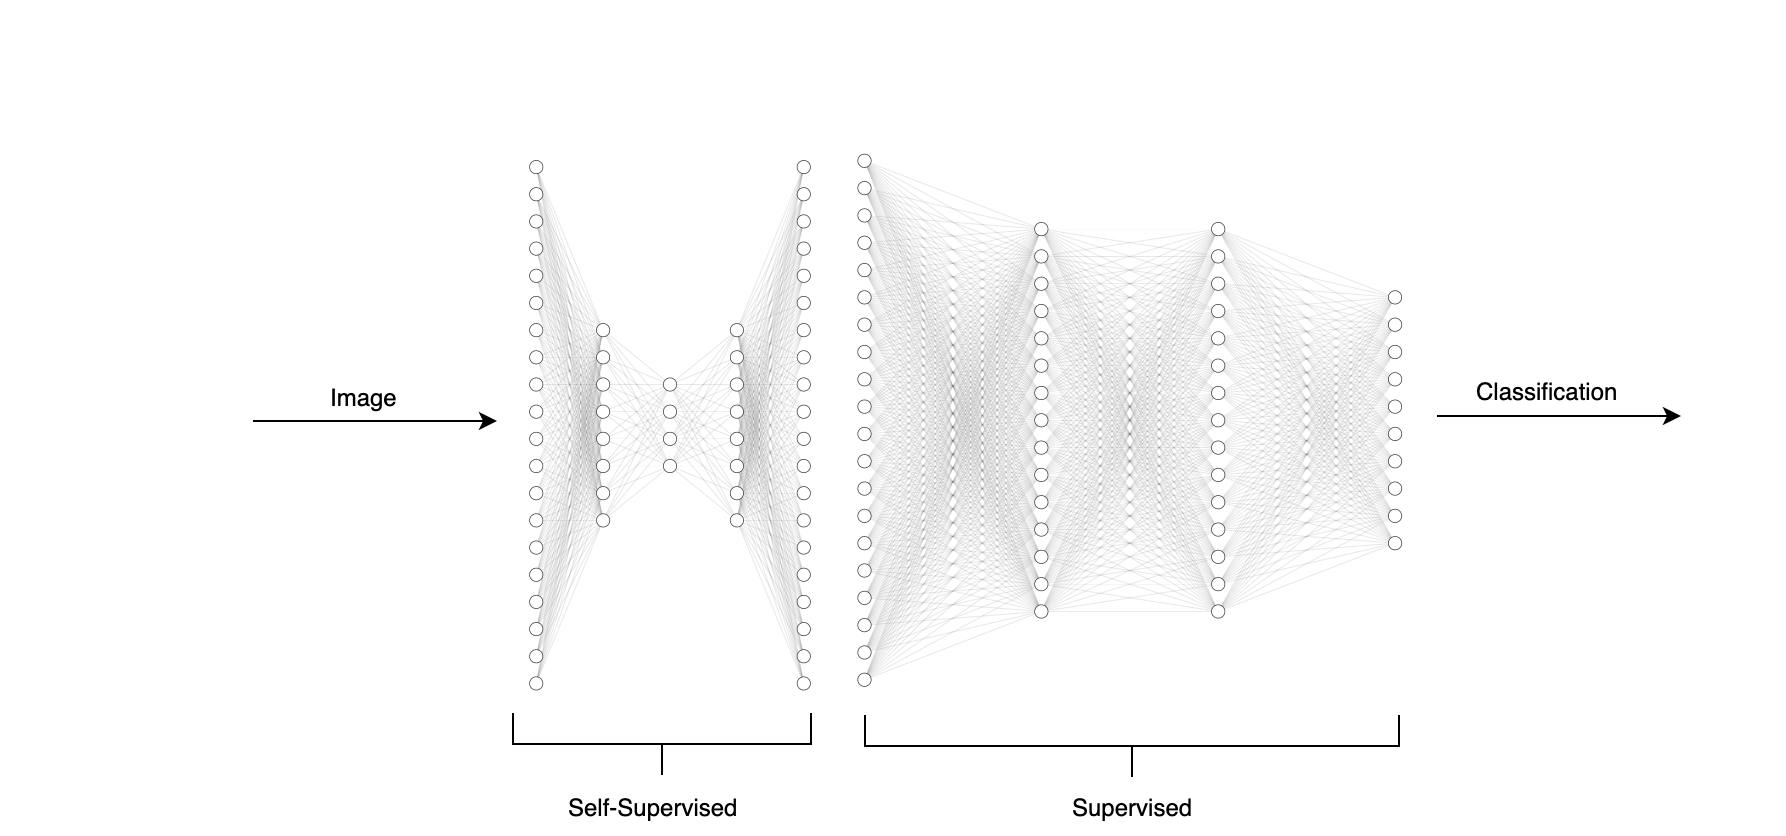

## Preparation

To help manage the models, we will use a helper function and `pickle` to store the models as files, and save them on the mounted Google Drive (and so copying the serializations on the current folder)

In [1]:
import pickle
# get the serialized object, or get a default value
def getFromFileOrDefault(filename, callback):
  try:
    return pickle.load(open(filename, "rb"))
  except (OSError, IOError) as e:
    print("exception thrown")
    print(e)
    obj = callback()
    with open(filename, 'wb') as handle:
      pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return obj

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/CC/Models/* ./

Mounted at /content/drive


## Importing dataset

First thing first, import the data.

We will use the Mnist digits dataset, so images of 28*28 pixels, and 10 classes.

To help up evaluating our models, we will use the first $10.000$ samples as test set, and the rest as training set

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import torch
import torchvision as tv
mnist_data = tv.datasets.MNIST('data/', train=True, download=True,
                                        transform=tv.transforms.Compose(
                                            [tv.transforms.ToTensor(),
                                             tv.transforms.Normalize((0.1307,), (0.3081,))]
                                        ))
mnist_data.data = (mnist_data.data.type(torch.FloatTensor)/255)

mnist_data_train = mnist_data.data[10000:, :]
mnist_targets_train = mnist_data.targets[10000:]

mnist_data_test = mnist_data.data[:10000, :]
mnist_targets_test = mnist_data.targets[:10000]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Let's visualize the data... here's one example of each class

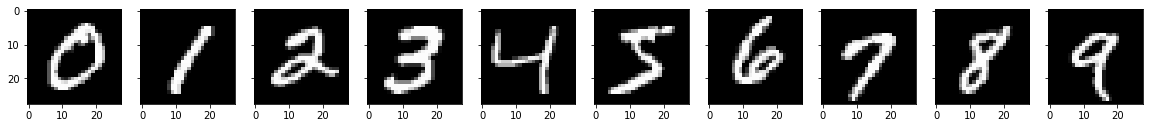

In [4]:
classes = set(mnist_data.targets.numpy())
examples = [mnist_data.data[np.where(mnist_data.targets == c)[0][0]] for c in classes]

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(examples[i].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

Following are the distribution of the classes on the test and training set

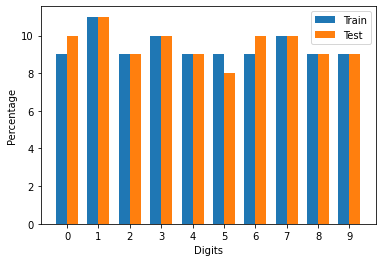

In [5]:
import matplotlib.pyplot as plt
import numpy as np



x = np.arange(10)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [int(sum(mnist_targets_train.numpy() == i) / len(mnist_targets_train) * 100) for i in classes], width, label='Train')
rects2 = ax.bar(x + width/2, [int(sum(mnist_targets_test.numpy() == i) / len(mnist_targets_test) * 100) for i in classes], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_xlabel('Digits')

ax.legend()
plt.xticks([i for i in classes])
plt.show()

## Building the self supervised model (autoencoder)

### Dense NN

I'll start from a very simple model, with a single layer for encoding and a single layer for decoding

In [6]:
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
encoding_dim = 32  # 32 floats -> compression of factor 24.5 with input 784 floats

input_img = keras.Input(shape=(784,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
es = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        patience = 8, 
                        verbose=1)

def train_autoencoder_one_layer():
  data_trans = np.reshape(mnist_data_train.numpy(), (len(mnist_data_train.numpy()), 784))
  autoencoder.fit(data_trans, data_trans, epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return autoencoder
autoencoder = getFromFileOrDefault('autoencoder_one_layer', train_autoencoder_one_layer)

After the training (should take around 7 minutes), we can check the reconstruction of the previous examples:

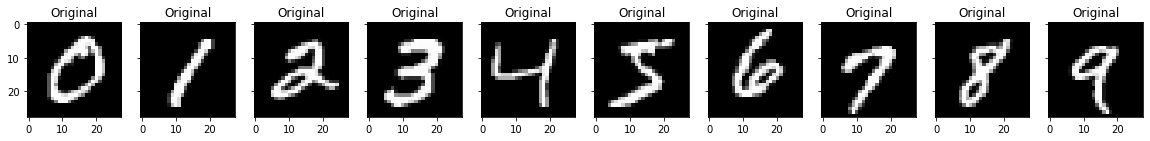

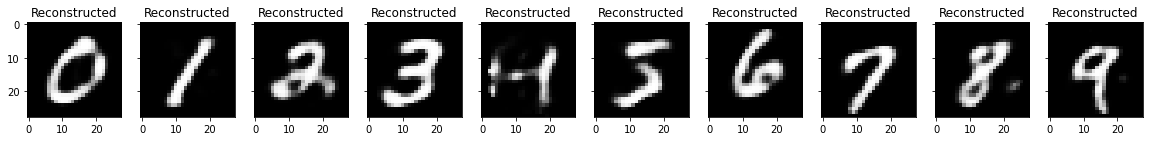

In [7]:

examples_predicted = autoencoder.predict(np.reshape([e.numpy() for e in examples], (len(examples), 784)))

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))

for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].title.set_text("Original")
  axes[ col].imshow(examples[i].reshape((28,28)), cmap=plt.cm.gray)

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].title.set_text("Reconstructed")
  axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)

as we can see, it's reconstructing the images in a "clear way", yet the loss is still high, so probably 1 layer is not powerfull enough... let's try adding some layers to make the model a bit more powerful

In [8]:
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
autoencoder_complex = Sequential([
    Input(shape=(784,)),
    Dense(units=80 , activation='relu'),
    Dense(units=encoding_dim , activation='relu'),
    Dense(units=80 , activation='relu'),
    Dense(784, activation='sigmoid')
])
autoencoder_complex.compile(optimizer='adam', loss='binary_crossentropy')
es = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        patience = 4, 
                        verbose=1)


def train_autoencoder_complex():
  data_trans = np.reshape(mnist_data_train.numpy(), (len(mnist_data_train.numpy()), 784))
  autoencoder_complex.fit(data_trans, data_trans, epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return autoencoder_complex

autoencoder_complex = getFromFileOrDefault('autoencoder_complex', train_autoencoder_complex)

After around 9  minutes, it should be done, and we can already see by the loss during training that it's slightly lower (0.0863 instead of 0.0941)... let's see the examples:

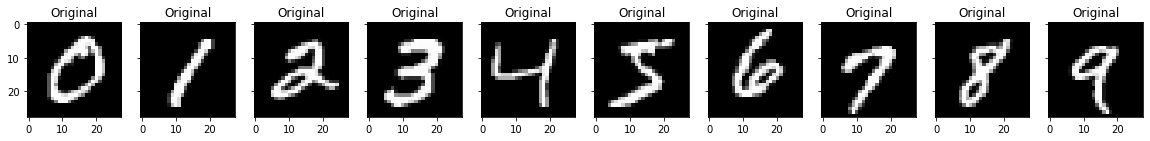

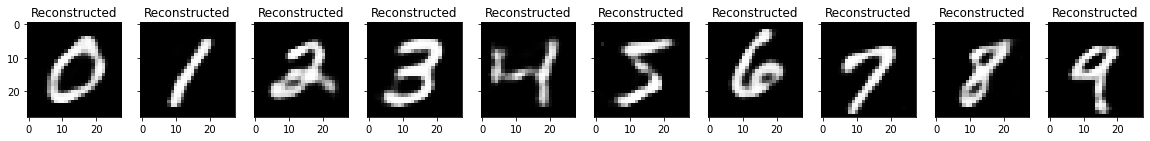

In [9]:

examples_predicted = autoencoder_complex.predict(np.reshape([e.numpy() for e in examples], (len(examples), 784)))

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].title.set_text("Original")
  axes[ col].imshow(examples[i].reshape((28,28)), cmap=plt.cm.gray)

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].title.set_text("Reconstructed")
  axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)

The difference is noticeable, mostly on the number 4, where before was almost an H, now it resembles a proper 4.


However, the aim of this "sub-network" is not reconstructing images, but removing noise, so we can train the network on the noised data, to see if it's able to learn how to remove noise

Let's try to train the autoencoder on perturbated data... to do so, we will inject some noise to the training data, and retrain the model from the ground up

In [10]:
import torch
def _inject_noise(data, noise_level):
  torch.manual_seed(0)
  random_gaussian_tensor = torch.randn(data.shape)/6.6 + .6
  probability_tensor = torch.ones(data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return data - mask_tensor * data + mask_tensor * random_gaussian_tensor

noised_mnist_data_train = _inject_noise(mnist_data_train, 0.3)
noised_mnist_data_test = _inject_noise(mnist_data_test, 0.3)

In [11]:
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
# This is the size of our encoded representations
encoding_dim = 32  
autoencoder_complex_noised = Sequential([
    Input(shape=(784,)),
    Dense(units=80 , activation='relu'),
    Dense(units=encoding_dim , activation='relu'),
    Dense(units=80 , activation='relu'),
    Dense(784, activation='sigmoid')
])
autoencoder_complex_noised.compile(optimizer='adam', loss='binary_crossentropy')
es = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        patience = 8, 
                        verbose=1)


def train_autoencoder_complex_noised(): 
  noised_data_trans = np.reshape(noised_mnist_data_train.numpy(), (len(noised_mnist_data_train.numpy()), 784))
  data_trans = np.reshape(mnist_data_train.numpy(), (len(mnist_data_train.numpy()), 784))
  autoencoder_complex_noised.fit(noised_data_trans, data_trans, epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return autoencoder_complex_noised

autoencoder_complex_noised = getFromFileOrDefault('autoencoder_complex_noised', train_autoencoder_complex_noised)

Let's now see this autoencoder trained on noisy data, what it can predict, and so how much noise can it remove (and also how able it is on non noisy data to reconstruct it)

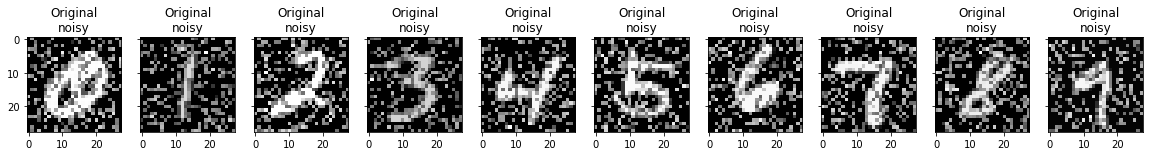

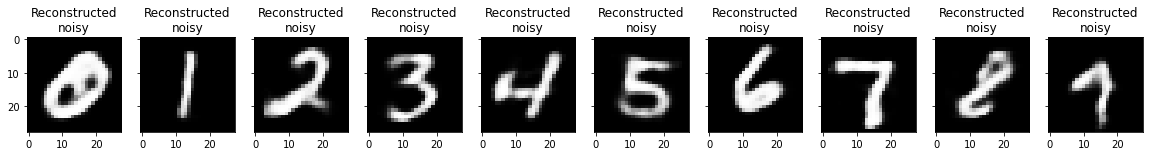

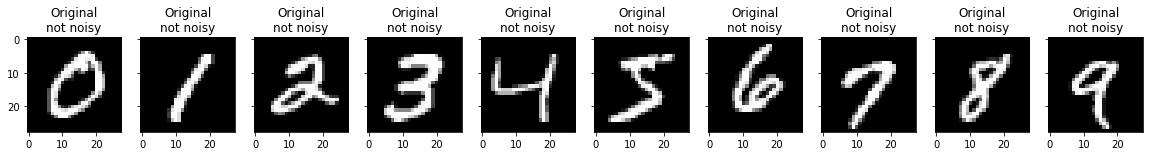

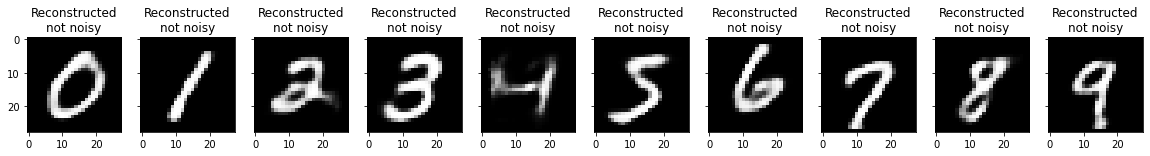

In [12]:
noised_examples = np.array([
      np.reshape(noised_mnist_data_train.numpy(), (len(noised_mnist_data_train.numpy()), 784))[
         np.where(mnist_targets_train == c)[0][0]
      ] for c in classes])
noised_examples = np.reshape(noised_examples, (len(noised_examples), 784))
examples_predicted = autoencoder_complex_noised.predict(noised_examples)

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].title.set_text("Original\nnoisy")
  axes[ col].imshow(noised_examples[i].reshape((28,28)), cmap=plt.cm.gray)

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].title.set_text("Reconstructed\nnoisy")
  axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)





num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].title.set_text("Original\nnot noisy")
  axes[ col].imshow(examples[i].reshape((28,28)), cmap=plt.cm.gray)

examples_predicted = autoencoder_complex_noised.predict(np.reshape(np.array([e.numpy() for e in examples]), (len(examples_predicted), 784)))
num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].title.set_text("Reconstructed\nnot noisy")
  axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)



I would say that the ability of the autoencoder to remove the noise is quite amazing... and so the decision to train the model on noised data, is been very helpful.
This also gives us an idea that the model is not just "removing white" pixels, but it actually learns what is considered noise. 

### Convolutional NN

To try other models, since we are dealing with images, why not try to see if CNN can achieve better accuracy:

In [13]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_cnn_noised = keras.Model(input_img, decoded)
autoencoder_cnn_noised.compile(optimizer='adam', loss='binary_crossentropy')

es = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        patience = 4, 
                        verbose=1)

def train_autoencoder_cnn_noised():
  noised_data_trans = noised_mnist_data_train.numpy()
  data_trans = mnist_data_train.numpy()
  autoencoder_cnn_noised.fit(noised_data_trans, data_trans, epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return autoencoder_cnn_noised

autoencoder_cnn_noised = getFromFileOrDefault('autoencoder_cnn_noised', train_autoencoder_cnn_noised)

We can already see that the loss is almost the same, so we do not expect any big difference... but the training took 52 minutes, comparing to the less than 18 of the previous model

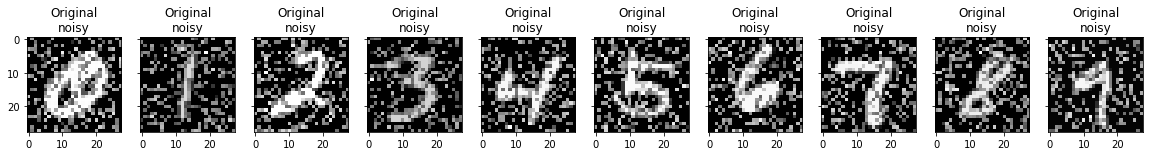

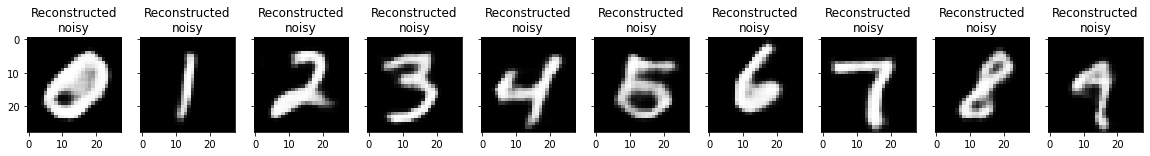

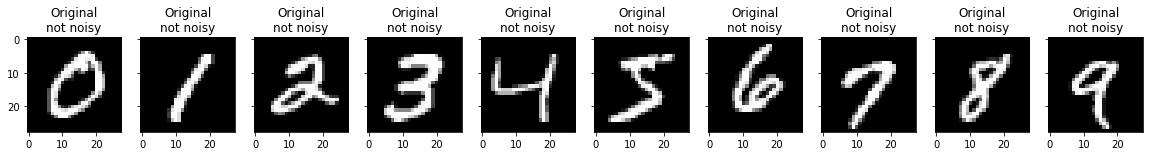

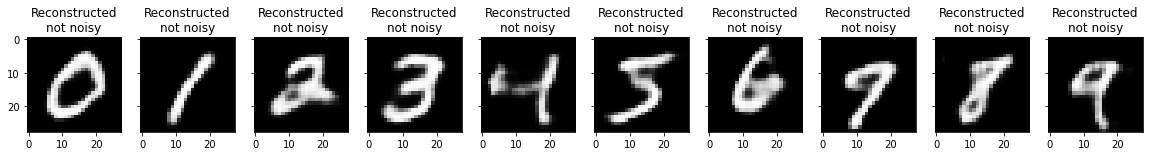

In [14]:
noised_examples = np.array([noised_mnist_data_train.numpy()[np.where(mnist_targets_train == c)[0][0]] for c in classes])
examples_predicted = autoencoder_cnn_noised.predict(noised_examples)

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].title.set_text("Original\nnoisy")
  axes[ col].imshow(noised_examples[i].reshape((28,28)), cmap=plt.cm.gray)

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].title.set_text("Reconstructed\nnoisy")
  axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)




num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].title.set_text("Original\nnot noisy")
  axes[ col].imshow(examples[i].reshape((28,28)), cmap=plt.cm.gray)

examples_predicted = autoencoder_cnn_noised.predict(np.array([e.numpy() for e in examples]))

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].title.set_text("Reconstructed\nnot noisy")
  axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)


Personally, the only difference I can see, is on the 4, but it's still working as expected

### Model comparison

Finally, we get to compare the two best models, too see how they respond to new data (test data), in both cases with noisy input and not.

Let's first prepare the data

In [15]:
# prepare data
classes = set(mnist_data.targets.numpy())
test_examples = np.array([
    mnist_data_test[np.where(mnist_targets_test == c)[0][0]].numpy()
    for c in classes
])
test_noised_examples = np.array([
    noised_mnist_data_test[np.where(mnist_targets_test == c)[0][0]] .numpy()
    for c in classes
])


Now we can check how it performs on perturbated data

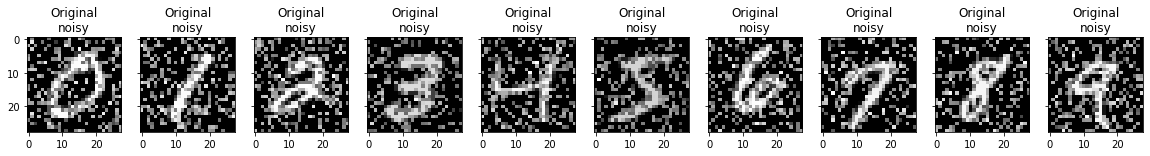

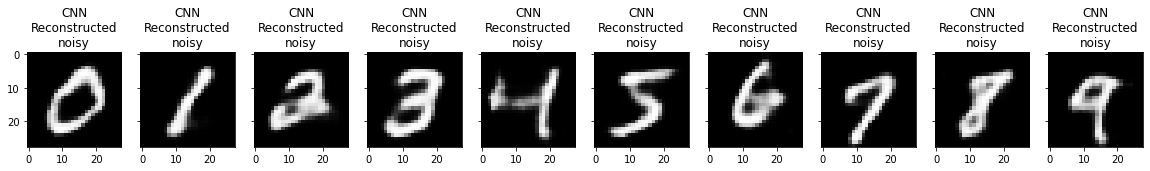

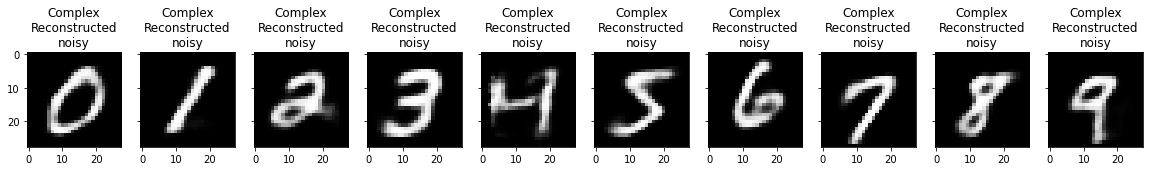

In [16]:
def free():
  test_noised_examples_predicted_cnn = autoencoder_cnn_noised.predict(test_noised_examples)
  test_noised_examples_predicted_complex = autoencoder_complex_noised.predict(np.reshape(test_noised_examples, (len(test_noised_examples), 784)))

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].title.set_text("Original\nnoisy")
    axes[ col].imshow(test_noised_examples[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].title.set_text("CNN\nReconstructed\nnoisy")
    axes[ col].imshow(test_noised_examples_predicted_cnn[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].title.set_text("Complex\nReconstructed\nnoisy")
    axes[ col].imshow(test_noised_examples_predicted_complex[i].reshape((28,28)), cmap=plt.cm.gray)

free()

And then let's see how it performs on original data

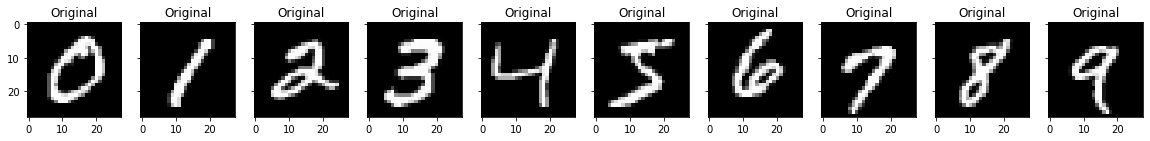

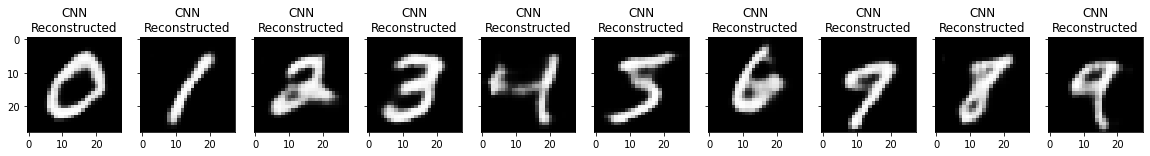

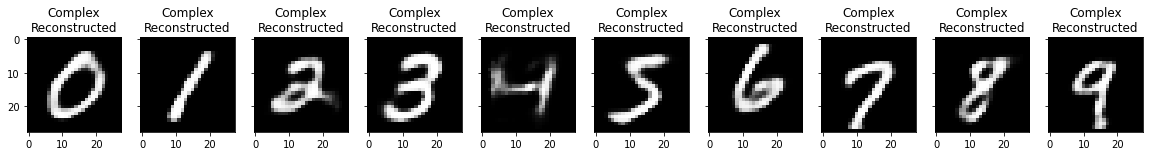

In [17]:
def free():
  test_examples_predicted_cnn = autoencoder_cnn_noised.predict(test_examples)
  test_examples_predicted_complex = autoencoder_complex_noised.predict(np.reshape(test_examples, (len(test_examples), 784)))

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].title.set_text("Original")
    axes[ col].imshow(test_examples[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].title.set_text("CNN\nReconstructed")
    axes[ col].imshow(test_examples_predicted_cnn[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].title.set_text("Complex\nReconstructed")
    axes[ col].imshow(test_examples_predicted_complex[i].reshape((28,28)), cmap=plt.cm.gray)

free()

Personally, on those 10 samples, I would say that the "complex" model with 3 layers, is better than the CNN

However, I would like to point out how the models have actually learnt what is noise in a very general way, infact we can see that if we start with a non noised element, there is almost no "white" removed, and so the models understand what is noise and what is the character.

This is even more evident, if we take the same model, and we train one copy with noised data, and another copy with non noised data, and we compare the final result on non noised data

We already have such model (the "complex" one), we have `autoencoder_complex` that is a dense NN trained on original data, and `autoencoder_complex_noised` that is trained on noised data... let's see the difference:

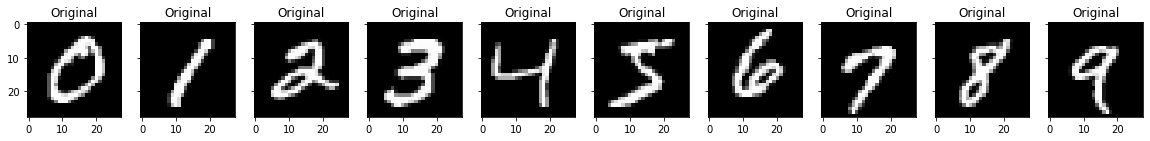

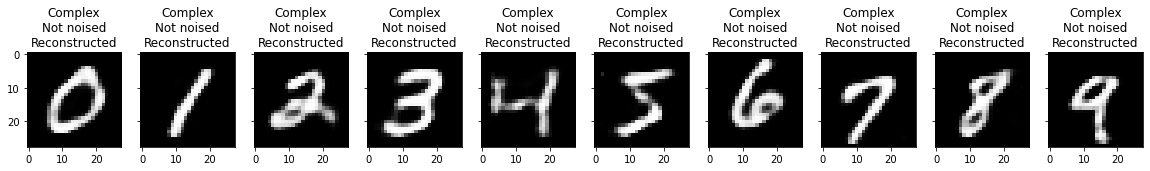

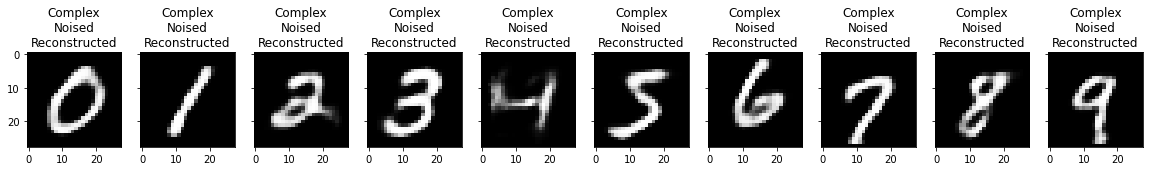

In [18]:
def free():
  #data
  classes = set(mnist_data.targets.numpy())
  test_examples = [mnist_data_test[np.where(mnist_targets_test == c)[0][0]].numpy() for c in classes]
  test_examples = np.reshape(test_examples, (len(test_examples), 784))
  test_examples_predicted_complex = autoencoder_complex.predict(test_examples)
  test_examples_predicted_complex_noised = autoencoder_complex_noised.predict(test_examples)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].title.set_text("Original")
    axes[ col].imshow(test_examples[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].title.set_text("Complex\nNot noised\nReconstructed")
    axes[ col].imshow(test_examples_predicted_complex[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].title.set_text("Complex\nNoised\nReconstructed")
    axes[ col].imshow(test_examples_predicted_complex_noised[i].reshape((28,28)), cmap=plt.cm.gray)

free()

I would say that there is no much difference between the model trained on original data (second line of images) and the one trained only on the perturbated images (third line of images).

The real difference is seen if we do the opposite, and so we test the "complex" models on noisy data, and see how much worst the model trained on original data performs in comparison to the one trained on perturbated data.

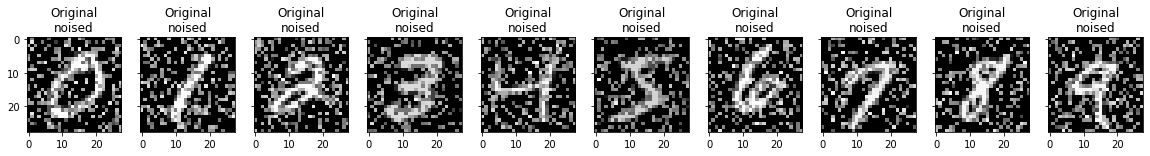

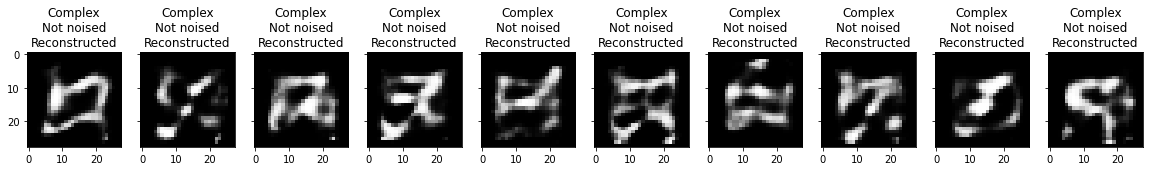

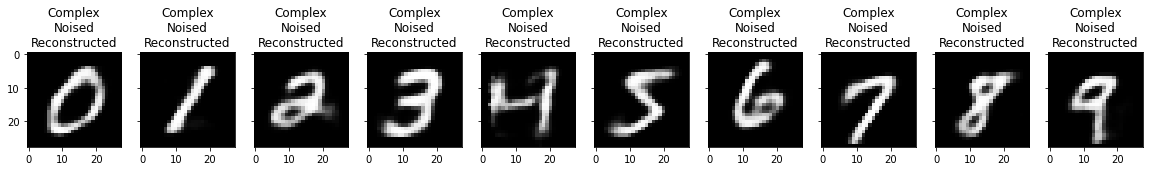

In [19]:
def free():
  #data
  classes = set(mnist_data.targets.numpy())
  test_examples_noised = [noised_mnist_data_test[np.where(mnist_targets_test == c)[0][0]].numpy() for c in classes]
  test_examples_noised = np.reshape(test_examples_noised, (len(test_examples_noised), 784))
  test_examples_predicted_complex = autoencoder_complex.predict(test_examples_noised)
  test_examples_predicted_complex_noised = autoencoder_complex_noised.predict(test_examples_noised)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].title.set_text("Original\nnoised")
    axes[ col].imshow(test_examples_noised[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].title.set_text("Complex\nNot noised\nReconstructed")
    axes[ col].imshow(test_examples_predicted_complex[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].title.set_text("Complex\nNoised\nReconstructed")
    axes[ col].imshow(test_examples_predicted_complex_noised[i].reshape((28,28)), cmap=plt.cm.gray)

free()

I would say that it's a very very bad result, and so we can say that even though the model trained on noisy data has a final loss higher (obviously because we are dealing with much more complex images) than the other one, it generalizes the data way better

### Conclusions

To conclude, let's test a final model, with even more depth, to see if we can get any better (and in addition to that, let's oversample the training set, by having copies of data with different noise level)

In [20]:
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
# This is the size of our encoded representations

autoencoder_deep_noised_augmented = Sequential([
    Input(shape=(784,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(784, activation='sigmoid')
])
autoencoder_deep_noised_augmented.compile(optimizer='adam', loss='binary_crossentropy')
es = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        patience = 8, 
                        verbose=1)

def train_autoencoder_deep_noised_augmented(): 
  noised_mnist_data_train_0 = _inject_noise(mnist_data_train, 0.0)
  noised_mnist_data_train_1 = _inject_noise(mnist_data_train, 0.1)
  noised_mnist_data_train_2 = _inject_noise(mnist_data_train, 0.2)
  noised_mnist_data_train_3 = _inject_noise(mnist_data_train, 0.3)
  noised_mnist_data_train_4 = _inject_noise(mnist_data_train, 0.4)
  noised_mnist_data_train_5 = _inject_noise(mnist_data_train, 0.5)
  noised_mnist_data_train_6 = _inject_noise(mnist_data_train, 0.6)
  noised_mnist_data_train_7 = _inject_noise(mnist_data_train, 0.7)

  noised_mnist_data_train_augemnted = np.concatenate((
      noised_mnist_data_train_0, 
      noised_mnist_data_train_1, 
      noised_mnist_data_train_2,
      noised_mnist_data_train_3,
      noised_mnist_data_train_4, 
      noised_mnist_data_train_5,
      noised_mnist_data_train_6, 
      noised_mnist_data_train_7
  ))
  targets_data_trans = np.concatenate((
      mnist_data_train, 
      mnist_data_train, 
      mnist_data_train,
      mnist_data_train,
      mnist_data_train, 
      mnist_data_train,
      mnist_data_train, 
      mnist_data_train
  ))

  noised_data_train_augemnted_trans = np.reshape(noised_mnist_data_train_augemnted, (len(noised_mnist_data_train_augemnted), 784))
  targets_data_trans = np.reshape(targets_data_trans, (len(targets_data_trans), 784))
  autoencoder_deep_noised_augmented.fit(noised_data_train_augemnted_trans, targets_data_trans, epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return autoencoder_deep_noised_augmented

autoencoder_deep_noised_augmented = getFromFileOrDefault('autoencoder_deep_noised_augmented', train_autoencoder_deep_noised_augmented)

After an hour and a half, the model trained on mutiple copies of the data with different levels of noise, should be trained, and now we can check the result of the reconstruction at different levels (we will compare it with the "complex model" seen before trained on perturbated data)

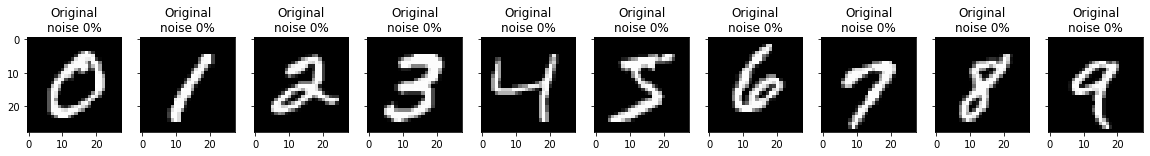

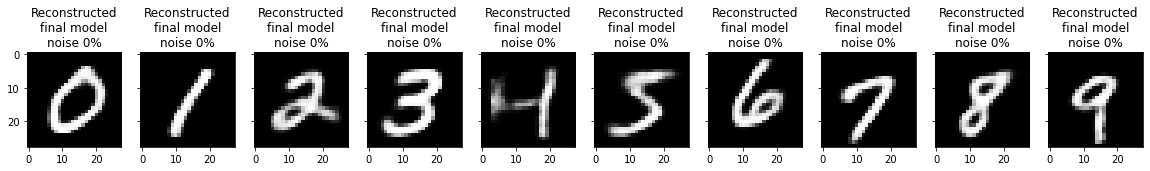

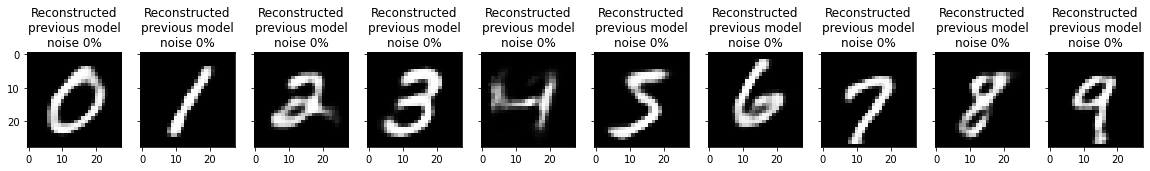

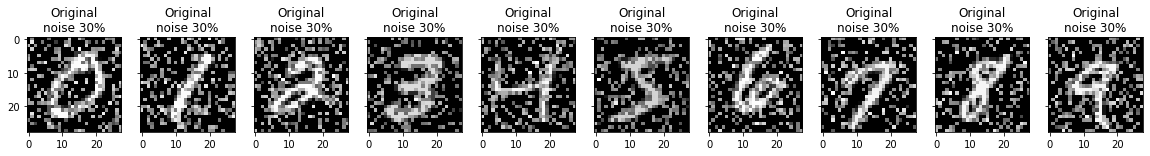

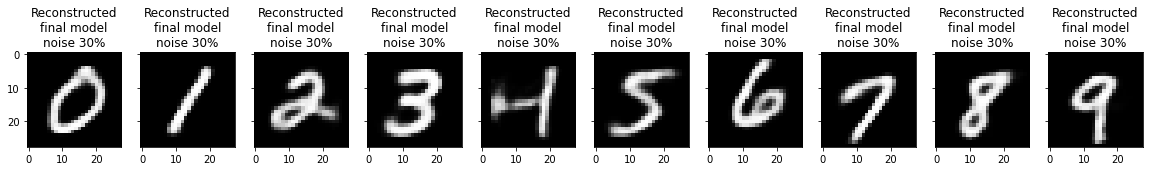

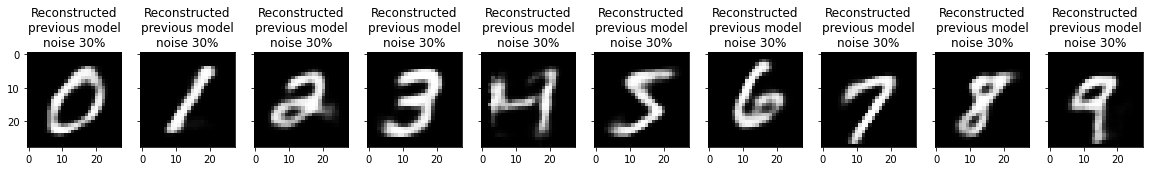

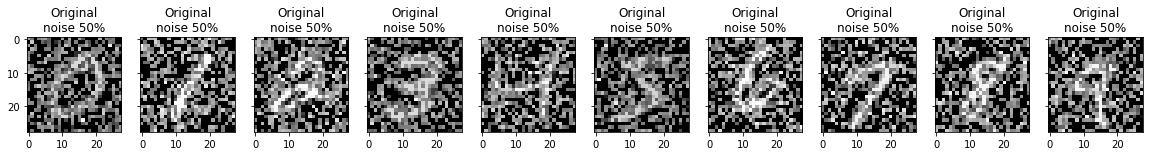

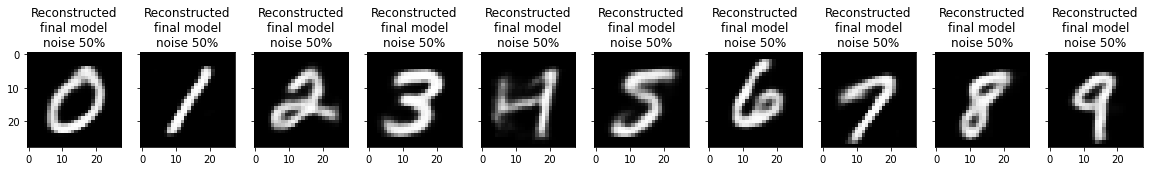

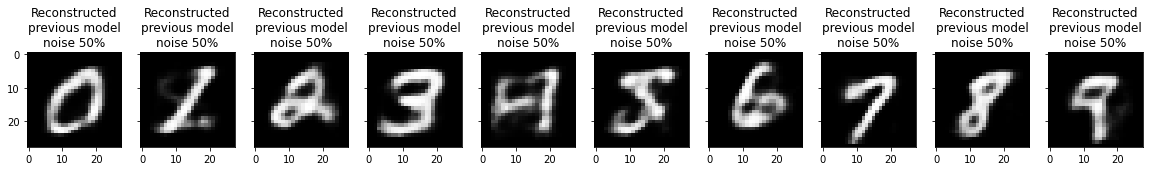

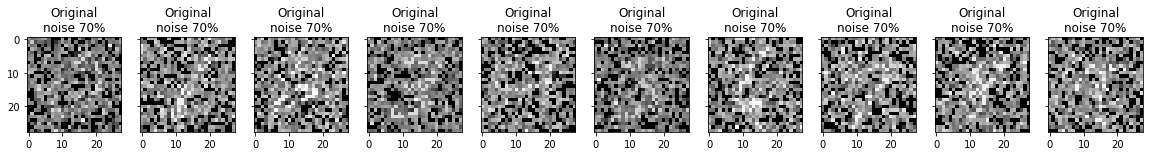

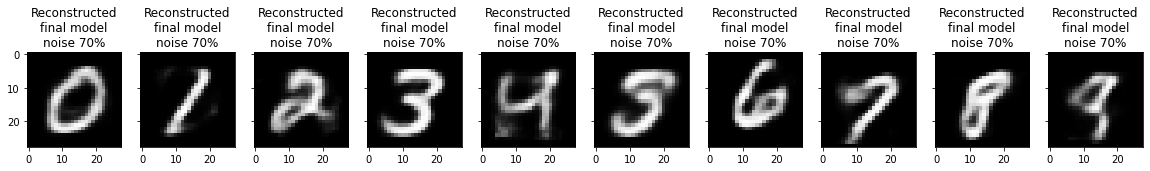

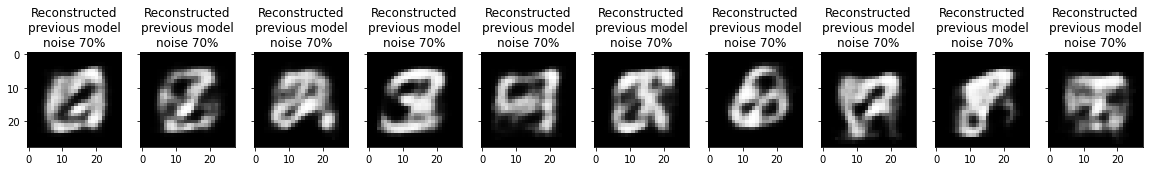

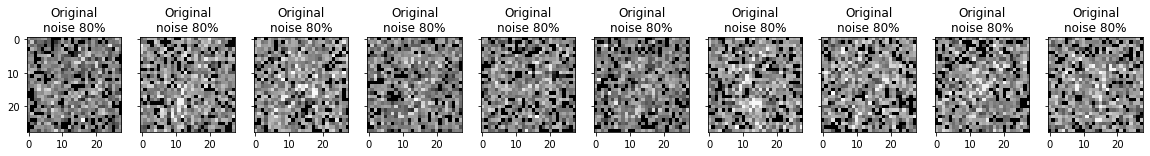

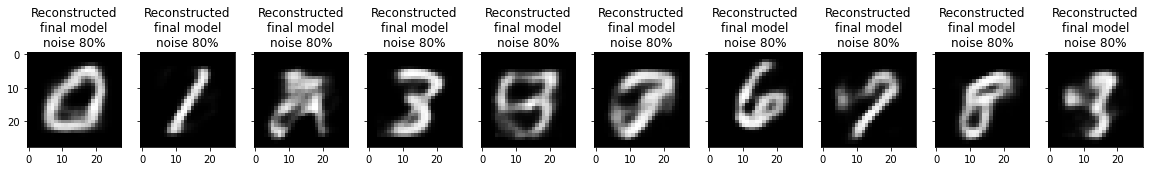

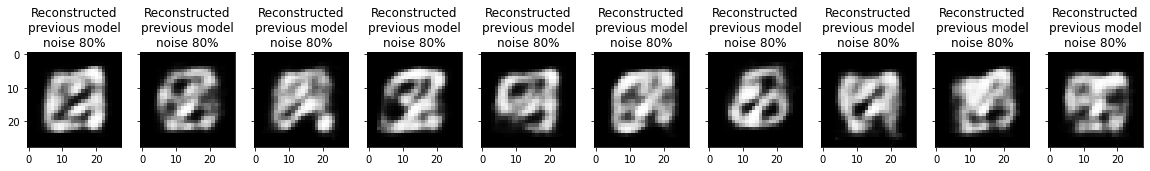

In [21]:
def free():
  for level in [0, 0.3, 0.5, 0.7, 0.8]:
    noisy_test_data = _inject_noise(mnist_data_test, level)
    very_noised_examples = np.reshape(noisy_test_data, (len(noisy_test_data), 784))
    very_noised_examples = np.array([very_noised_examples[np.where(mnist_targets_test == c)[0][0]].numpy() for c in classes])
    very_noised_examples = np.reshape(very_noised_examples, (len(very_noised_examples), 784))


    examples_predicted = autoencoder_deep_noised_augmented.predict(very_noised_examples)

    num_subplots = 10
    n_rows_cols = 1
    fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
    for i in range(num_subplots):
      row = i % n_rows_cols
      col = i // n_rows_cols
      axes[ col].title.set_text(f"Original\nnoise {int(level*100)}%")
      axes[ col].imshow(very_noised_examples[i].reshape((28,28)), cmap=plt.cm.gray)
    num_subplots = 10
    n_rows_cols = 1
    fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
    for i in range(num_subplots):
      row = i % n_rows_cols
      col = i // n_rows_cols
      axes[ col].title.set_text(f"Reconstructed\nfinal model\nnoise {int(level*100)}%")
      axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)

    test_examples_predicted_complex_noised = autoencoder_complex_noised.predict(very_noised_examples)
    num_subplots = 10
    n_rows_cols = 1
    fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
    for i in range(num_subplots):
      row = i % n_rows_cols
      col = i // n_rows_cols
      axes[ col].title.set_text(f"Reconstructed\nprevious model\nnoise {int(level*100)}%")
      axes[ col].imshow(test_examples_predicted_complex_noised[i].reshape((28,28)), cmap=plt.cm.gray)


free()

To me, this is by far the best model... we can clearly see that increasing the error, the previous model completely messes the data, and so training the other model with different levels of noises allowed it to have an even better concept of noise also at higher percentege (those are images from the test set, so images never seen before by the model)

In the image it's also reported the reconstruction for 80% of perturbation, which is not bad, some of the numbers are still recognizable

What we can also do, is try to feed the autoencoder the image that it itself has produced as output, to see if it helps to converge to a better final image

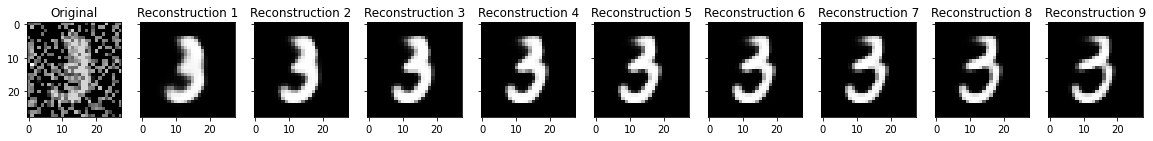

In [22]:
def free():
  classes = set(mnist_data.targets.numpy())
  test_example_noised = _inject_noise(mnist_data_test[10], 0.4).numpy()
  test_example_noised = np.reshape(test_example_noised, (1, 784))
  pred = [test_example_noised]
  
  for i in range(0, 10):
    pred.append(autoencoder_deep_noised_augmented.predict(pred[-1]))
  
  
  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    if i == 0:
      axes[ col].title.set_text("Original")
    else:
      axes[ col].title.set_text(f"Reconstruction {i}")
    axes[ col].imshow(pred[i].reshape((28,28)), cmap=plt.cm.gray)

free()

We can also try with even more steps:

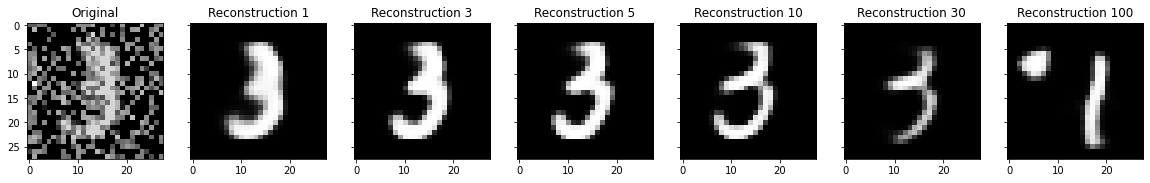

In [23]:
def free():
  classes = set(mnist_data.targets.numpy())
  test_example_noised = _inject_noise(mnist_data_test[10], 0.4).numpy()
  test_example_noised = np.reshape(test_example_noised, (1, 784))
  pred = [test_example_noised]
  
  for j in [1,3,5,10,30,100]:
    rec = test_example_noised
    for i in range(0, j):
      rec = autoencoder_deep_noised_augmented.predict(rec)
    pred.append(rec)
  
  
  num_subplots = 7
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    if i == 0:
      axes[ col].title.set_text("Original")
    else:
      axes[ col].title.set_text(f"Reconstruction {[1,3,5,10,30,100][i-1]}")
    axes[ col].imshow(pred[i].reshape((28,28)), cmap=plt.cm.gray)

free()

### Final evaluation

Let's now try to find a more formal way to calculate the accuracy of the reconstructions.

For the loss, we have no big problems, and to keep the things simple, we can consider just the Mean Square Error of the reconstruction against the original function.

For the accuracy, I was not able to find any bounded accuracy measure to calculate the error, so I think I'll have to come up with one by myself.  
For that, let's formulate the following accuracy:

$$
SingleAcc(prediction, target) = 1-\frac{\sum_{i=0}^{|prediction|}|prediction_i - target_i|}{\sum_{i=0}^{|target|}max(1-target_i\:,\: target_i)}\\[30pt]
FinalAcc(prediction, target) = \frac{\sum_{i=0}^{|predictions|}SingleAcc(predictions^{(i)}, targets^{(i)})}{|predictions|}
$$

Where: 
 - $SingleAcc$ takes a single prediction vector and a single target vector, and calculate the distance between the prediction and the target, and divide it by the highest error possible, which is the max between $1-target_i$ and $target_i$ (if we have a pixel with $0.2$ brightness, at most we can have a $0.8$ error)
 - $FinalAcc$ takes a vector of predictions and targets, and calculates the average error


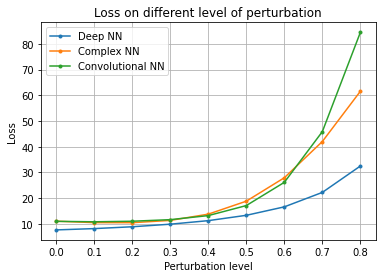

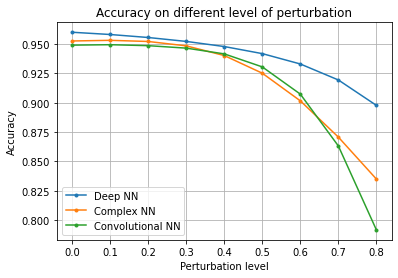

In [24]:
def mse(preds, targets):
  return np.sum((preds-targets)*(preds-targets))/len(targets)

def single_acc(pred, target):
  return 1-(np.abs(pred-target)/np.maximum(target, 1-target))
def final_acc(preds, targets):
  single_accs = [single_acc(pred, target) for (pred, target) in zip(preds, targets)] 
  return np.mean(single_accs)

def free():
  mses = {
      "deep" : [],
      'complex' : [], 
      'cnn' : [],
  }
  accs = {
      "deep" : [],
      'complex' : [], 
      'cnn' : [],
  }
  for level in np.linspace(0,0.8,9):
    test_trans_data = _inject_noise(mnist_data_test, level)
    targets = mnist_data_test.numpy().reshape((len(mnist_data_test), 784))


    predictions = autoencoder_deep_noised_augmented.predict(test_trans_data.numpy().reshape(len(mnist_data_test), 784))
    mses['deep'].append(mse(predictions, targets))
    accs['deep'].append(final_acc(predictions, targets))

    predictions = autoencoder_complex_noised.predict(test_trans_data.numpy().reshape(len(mnist_data_test), 784))
    mses['complex'].append(mse(predictions, targets))
    accs['complex'].append(final_acc(predictions, targets))

    predictions = autoencoder_cnn_noised.predict(test_trans_data.numpy())
    mses['cnn'].append(mse(predictions.reshape((len(predictions), 784)), targets))
    accs['cnn'].append(final_acc(predictions.reshape((len(predictions), 784)), targets))
  plt.plot(
    np.linspace(0,0.8,9),
    mses['deep'],
    marker = 'o',
    markersize = 3
  )
  plt.plot(
    np.linspace(0,0.8,9),
    mses['complex'],
    marker = 'o',
    markersize = 3
  )
  plt.plot(
    np.linspace(0,0.8,9),
    mses['cnn'],
    marker = 'o',
    markersize = 3
  )

  plt.title(f'Loss on different level of perturbation')
  plt.ylabel('Loss')
  plt.xlabel('Perturbation level')
  plt.grid()
  plt.legend(['Deep NN', "Complex NN", "Convolutional NN"], loc = 'best')
  plt.show()




  plt.plot(
    np.linspace(0,0.8,9),
    accs['deep'],
    marker = 'o',
    markersize = 3
  )
  plt.plot(
    np.linspace(0,0.8,9),
    accs['complex'],
    marker = 'o',
    markersize = 3
  )
  plt.plot(
    np.linspace(0,0.8,9),
    accs['cnn'],
    marker = 'o',
    markersize = 3
  )

  plt.title(f'Accuracy on different level of perturbation')
  plt.ylabel('Accuracy')
  plt.xlabel('Perturbation level')
  plt.grid()
  plt.legend(['Deep NN', "Complex NN", "Convolutional NN"], loc = 'best')
  plt.show()

free()


This accuracy is a bit unfair, since most of each image is empty, and so even if the model would had generated empty image, the accuracy would still be good, but it's the best I could come up.

However, clearly the final Deep Neural Network trained on more data with different levels of noises, wins.

To conclude, let's see the accuracy on each digit, so we can see if they are all equally reconstructable

In [25]:
digits_accs = {}
def free():
  for level in np.linspace(0,0.8,9):
    for c in set(mnist_targets_test.numpy()):
      if c not in digits_accs.keys():
        digits_accs[c] = []
      targets = mnist_data_test[np.where(mnist_targets_test == c)]
      test_trans_data = _inject_noise(targets, level).numpy()
      test_trans_data = test_trans_data.reshape((len(targets), 784))
      targets = targets.numpy().reshape((len(targets), 784))
      
      predictions = autoencoder_deep_noised_augmented.predict(test_trans_data)
      digits_accs[c].append(final_acc(predictions, targets))

free()

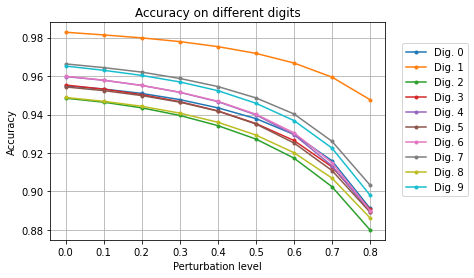

In [26]:
for d in digits_accs.values():
  plt.plot(
    np.linspace(0,0.8,9),
    d,
    marker = 'o',
    markersize = 3
  )

plt.title(f'Accuracy on different digits')
plt.ylabel('Accuracy')
plt.xlabel('Perturbation level')
plt.grid()
plt.legend([f"Dig. {i}" for i in range(0,10)], loc = (1.05,0.2))
plt.show()

We can see that not all numbers are equally easily reconstructable, but we will keep still this model since it's still performing well 

We can now check the accuracy with reconstruction:

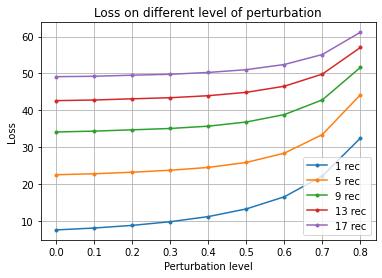

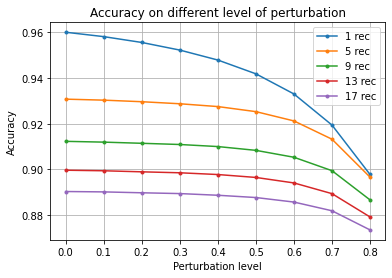

In [27]:

def free():
  mses = {}
  accs = {}
  for rec in range(1,20, 4):
    mses[f"{rec}"] = []
    accs[f"{rec}"] = []
    for level in np.linspace(0,0.8,9):
      test_trans_data = _inject_noise(mnist_data_test, level)
      test_trans_data = test_trans_data.reshape(len(test_trans_data), 784).numpy()
      targets = mnist_data_test.numpy().reshape((len(mnist_data_test), 784))
      predictions = test_trans_data
      for _ in range(0, rec):
        predictions = autoencoder_deep_noised_augmented.predict(predictions)
      mses[f"{rec}"].append(mse(predictions, targets))
      accs[f"{rec}"].append(final_acc(predictions, targets))

  leg = []
  for k,v in mses.items():
    leg.append(f"{k} rec")
    plt.plot(
      np.linspace(0,0.8,9),
      mses[k],
      marker = 'o',
      markersize = 3
    )

  plt.title(f'Loss on different level of perturbation')
  plt.ylabel('Loss')
  plt.xlabel('Perturbation level')
  plt.grid()
  plt.legend(leg, loc = 'best')
  plt.show()


  leg = []
  for k,v in accs.items():
    leg.append(f"{k} rec")
    plt.plot(
      np.linspace(0,0.8,9),
      accs[k],
      marker = 'o',
      markersize = 3
    )

  plt.title(f'Accuracy on different level of perturbation')
  plt.ylabel('Accuracy')
  plt.xlabel('Perturbation level')
  plt.grid()
  plt.legend(leg, loc = 'best')
  plt.show()


free()

## Building the unsupervised model (DBN)

This part should be trivial, since we can take inspiration from the code provided for the laboratory

### Import library

In [28]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [29]:
%%capture
get_dbn_library()

In [30]:
from DBN import DBN

At this point, we have to train the unsupervised model from the original data, and we will then use this model for both the variations (with and without autoencoder)



### Training

Let's start from the first one.

We can easily do that by using the code from the laboratories and train it from the training set

In [31]:
def train_dbn_from_original():
  dbn = DBN(visible_units=28*28,
      hidden_units=[500],
      k=1,
      learning_rate=0.1,
      learning_rate_decay=False,
      initial_momentum=0.5,
      final_momentum=0.9,
      weight_decay=0.0002,
      xavier_init=False,
      increase_to_cd_k=False,
      use_gpu=True)
  dbn.train_static(
      mnist_data_train,
      mnist_targets_train,
      500,
      1024
  )
  return dbn
dbn_from_original = getFromFileOrDefault("dbn_from_original", train_dbn_from_original)

Let's check the receptive fields of the DBN

In [32]:
def _move_parameters_to_cpu(dbn_mnist):
  for layer in dbn_mnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()
def _apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def _plot_layer_receptive_fields(weights, num_subplots = 100):
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray) 

In [33]:
_move_parameters_to_cpu(dbn_from_original)

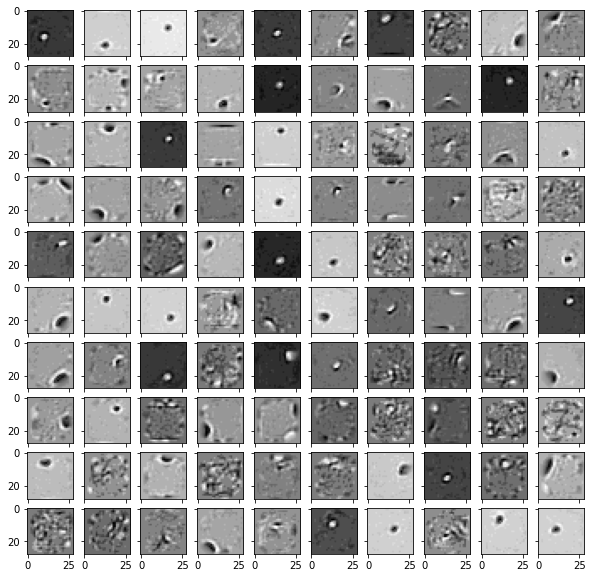

In [34]:
def free():
  learned_weights_layer_1 = dbn_from_original.rbm_layers[0].W.transpose(0,1).numpy()
  learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)

  _plot_layer_receptive_fields(learned_weights_layer_1)

free()

We can still see that the hidden units are responding to specific areas on the images, as expected, and so they will fire only if a specific area of the image is "bright"

Let's build a dendogram to see how much similar are the digits for the DBN

In [35]:
def _get_last_layer_repr(input,):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_from_original.forward(flattened_input)  
  return hidden_repr

def _get_mask(label):  
  labels = mnist_targets_train.numpy()
  return labels == label

def _get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.numpy()
  return {
    label: hidden_representation_np[_get_mask(label)].mean(axis=0)  
    for label in range(10)
  }

def _get_hidden_reprs_matrix(label_to_mean_hidd_repr):  
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  
    for label in range(10)])
def _plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

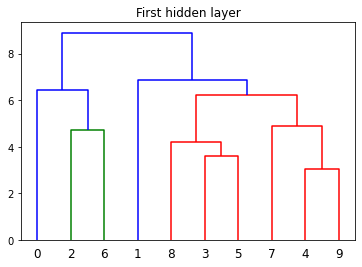

In [36]:
def free():
  outputs = _get_last_layer_repr(mnist_data_train)
  label_to_mean_hidd_repr = _get_label_to_mean_hidd_repr(outputs)
  mean_hidd_repr_matrix = _get_hidden_reprs_matrix(label_to_mean_hidd_repr)
  _plot_dendrogram(mean_hidd_repr_matrix, "First hidden layer")

free()

## Building the supervised model (Perceptron and NN)

During the course, we have used DBN+Perceptron to have linear readouts from the last layer, and so we will use that as benchmark.

On the other side, we have the models that we built:
 1. the self-supervised autoencoder
 2. the DBN 

so we can build 2 final models to compare with the lab one:
 1. AE+DBN+Readout
 2. AE+Readout
However, the AE autoencoder has no power over how much the data is linearly separable, so we will use a bit more complex network, just to make the comparison fair

Here's the final 3 models that we will test:
 1. DBN+Perceptron (lab one)
 2. AE+DBN+Perceptron 
 3. AE+Deep Dense NN



### DBN+Perceptron


In [37]:
from sklearn.datasets import load_digits
from sklearn.linear_model import Perceptron
def train_perceptron_for_dbn_lab():
  hidden_repr_layer_3_train = _get_last_layer_repr(mnist_data_train).numpy()

  perceptron_for_dbn_lab = Perceptron(tol=1e-3, random_state=0)
  perceptron_for_dbn_lab.fit(hidden_repr_layer_3_train, mnist_targets_train)
  return perceptron_for_dbn_lab

perceptron_for_dbn_lab = getFromFileOrDefault('perceptron_for_dbn_lab', train_perceptron_for_dbn_lab)

In [38]:
f"{perceptron_for_dbn_lab.score(_get_last_layer_repr(mnist_data_test).numpy(), mnist_targets_test)*100}% accuracy on test data"

'94.96% accuracy on test data'

Pretty nice result, on clean data

### AE+DBN+Perceptron

First, let's find out how to pass the result of the autoencoder to the DBN

In [39]:
def train_perceptron_for_dbn_autoencoder():
  predictions = autoencoder_deep_noised_augmented.predict(mnist_data_train.reshape((len(mnist_data_train), 784)).numpy())
  predictions = predictions.reshape(len(predictions), 28, 28)
  hidden_repr_layer_3_train = _get_last_layer_repr(torch.from_numpy(predictions)).numpy()

  perceptron_for_dbn_autoencoder = Perceptron(tol=1e-3, random_state=0)
  perceptron_for_dbn_autoencoder.fit(hidden_repr_layer_3_train, mnist_targets_train.numpy())
  return perceptron_for_dbn_autoencoder

perceptron_for_dbn_autoencoder = getFromFileOrDefault("perceptron_for_dbn_autoencoder", train_perceptron_for_dbn_autoencoder)


In [40]:
f"{perceptron_for_dbn_autoencoder.score(_get_last_layer_repr(mnist_data_test).numpy(), mnist_targets_test)*100}% accuracy on test data"

'91.49000000000001% accuracy on test data'

The precision is worse than just DBN+Perceptron, but this might be due to the loss of details/clear delimiters on the decoded images feeded to the DBN (also recall that the DBN is trained on the initial data, and not on the transformed one)

However, we are not here to find the model that best fits the data, but the one more robust on noises

### AE+NN


So let's now train a deep dense NN that will have to classify the decoder output.

To be fair with the DBN, we will use a NN with 3 layers with 500 neurons each, and a final softmax readout layer

In [41]:
from tensorflow.keras.utils import to_categorical
def train_neural_network_for_autoencoder():
  inputs = autoencoder_deep_noised_augmented.predict(mnist_data_train.reshape((len(mnist_data_train), 784)).numpy())
  model = Sequential([
      Dense(input_dim = 784, units=500, activation='relu'),
      Dense(units=500, activation='relu'),
      Dense(units=500, activation='relu'),
      Dense(units=10, activation='softmax'),
  ])
  model.compile(loss='categorical_crossentropy', 
        optimizer='sgd',  
        metrics=['accuracy']) 

  es = EarlyStopping(monitor='val_loss', 
                    mode='min', 
                    patience = 8, 
                    verbose=1)
  model.fit(inputs, to_categorical(mnist_targets_train.numpy(), num_classes=10), epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return model

neural_network_for_autoencoder = getFromFileOrDefault('neural_network_for_autoencoder', train_neural_network_for_autoencoder)


In [42]:
from sklearn.metrics import accuracy_score
print(f"{accuracy_score(mnist_targets_test, np.argmax(neural_network_for_autoencoder.predict(autoencoder_deep_noised_augmented.predict(mnist_data_test.reshape((len(mnist_data_test), 784)).numpy())), axis=1)) *100}% accuracy on test data")

97.16% accuracy on test data


This is even better than DBN+Perceptron, even though it might be thanks to the final deep NN, compared to the autoencoder

### AE + Perceptron


In [56]:
def train_perceptron_for_autoencoder():
  perceptron_for_autoencoder = Perceptron(tol=1e-3, random_state=0)
  perceptron_for_autoencoder.fit(mnist_data_train.reshape((len(mnist_data_train), 784)), mnist_targets_train)
  return perceptron_for_autoencoder

perceptron_for_autoencoder = getFromFileOrDefault("perceptron_for_autoencoder", train_perceptron_for_autoencoder)


In [55]:
!cp perceptron_for_autoencoder drive/MyDrive/CC/Models/perceptron_for_autoencoder

## Prepare model for the evaluation

### Preparation

We have arrived to the point that we wanted, which is the comparison between:
 - DBN+Perceptron
 - Autoencoder+NN
 - Autoencoder+DBN+Perceptron

compared on noisy data

In [44]:
# functions to get predictions
def pred_DBN_Perceptron(data, reconstructions=0):
  if data.shape != (len(data), 28, 28):
    data = data.reshape((len(data), 28, 28))
  for __ in range(0, reconstructions):
    data, __ = dbn_from_original.reconstruct(data)
  if torch.is_tensor(data) == False:
    data = torch.from_numpy(data)
  # compute the representation of the data on the last layer
  hidden_repr_layer_3_train = _get_last_layer_repr(data).numpy()
  # feed the predictions to the Perceptron
  return perceptron_for_dbn_lab.predict(hidden_repr_layer_3_train)

def pred_Autoencoder_Perceptron(data):
  if data.shape != (len(data), 784):
    data = data.reshape((len(data), 784))
  if isinstance(data, np.ndarray) == False:
    data = data.numpy()
  # compute the representation of the data on the last layer
  predictions = autoencoder_deep_noised_augmented.predict(data)
  # feed the predictions to the Perceptron
  return perceptron_for_autoencoder.predict(predictions)



def pred_Autoencoder_DBN_Perceptron(data, ae_reconstructions=0, dbn_reconstructions=0):
  if data.shape != (len(data), 784):
    data = data.reshape((len(data), 784))
  for __ in range(0, dbn_reconstructions):
    data, __ = dbn_from_original.reconstruct(data)
  if isinstance(data, np.ndarray) == False:
    data = data.numpy()
  # compute predictions for the autoencoder
  predictions = autoencoder_deep_noised_augmented.predict(data)
  for i in range(0, ae_reconstructions):
    predictions = autoencoder_deep_noised_augmented.predict(predictions)
  # reshape predictions for the DBN
  predictions = predictions.reshape(len(predictions), 28, 28)
  # compute the representation of the feeded predictions on the last layer
  hidden_repr_layer_3_train = _get_last_layer_repr(torch.from_numpy(predictions)).numpy()
  # feed the predictions to the Perceptron
  return perceptron_for_dbn_autoencoder.predict(hidden_repr_layer_3_train)


def pred_Autoencoder_NN(data, ae_reconstructions=0):
  if data.shape != (len(data), 784):
    data = data.reshape((len(data), 784))
  if isinstance(data, np.ndarray) == False:
    data = data.numpy()
  # compute predictions for the autoencoder
  predictions = autoencoder_deep_noised_augmented.predict(data)
  for i in range(0, ae_reconstructions):
    predictions = autoencoder_deep_noised_augmented.predict(predictions)
  # feed the predictions to the NN and find the argmax to know which digit is predicted
  return np.argmax(neural_network_for_autoencoder.predict(predictions), axis=1)



### Evaluation

Now we have just left to generate some noisy data, and see how the different models respond to that.

To evaluate performance, since the data is pretty balanced, we will use _accuracy_

To be fair, during the course, we have also seen that DBN can reconstruct images, so we will test also the precision with reconstructed images

In [45]:
accuracies = {
    'dbn_perceptron_0': [],
    'dbn_perceptron_1': [],
    'dbn_perceptron_2': [],
    'dbn_perceptron_3': [],
    'autoencoder_dbn_perceptron_0': [],
    'autoencoder_dbn_perceptron_1': [],
    'autoencoder_dbn_perceptron_2': [],
    'autoencoder_dbn_perceptron_3': [],
    'autoencoder_0_dbn_perceptron': [],
    'autoencoder_1_dbn_perceptron': [],
    'autoencoder_2_dbn_perceptron': [],
    'autoencoder_5_dbn_perceptron': [],
    'autoencoder_perceptron': [],
    'autoencoder_0_nn': [],
    'autoencoder_1_nn': [],
    'autoencoder_2_nn': [],
    'autoencoder_5_nn': []
}
def free():
  for level in np.linspace(0,0.9,10):
    noisy_test_data = _inject_noise(mnist_data_test, level)

    accuracies['dbn_perceptron_0'].append(accuracy_score(pred_DBN_Perceptron(noisy_test_data, reconstructions=0), mnist_targets_test))
    accuracies['dbn_perceptron_1'].append(accuracy_score(pred_DBN_Perceptron(noisy_test_data, reconstructions=1), mnist_targets_test))
    accuracies['dbn_perceptron_2'].append(accuracy_score(pred_DBN_Perceptron(noisy_test_data, reconstructions=2), mnist_targets_test))
    accuracies['dbn_perceptron_3'].append(accuracy_score(pred_DBN_Perceptron(noisy_test_data, reconstructions=3), mnist_targets_test))
    accuracies['autoencoder_dbn_perceptron_0'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, dbn_reconstructions=0), mnist_targets_test))
    accuracies['autoencoder_dbn_perceptron_1'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, dbn_reconstructions=1), mnist_targets_test))
    accuracies['autoencoder_dbn_perceptron_2'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, dbn_reconstructions=2), mnist_targets_test))
    accuracies['autoencoder_dbn_perceptron_3'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, dbn_reconstructions=3), mnist_targets_test))
    accuracies['autoencoder_0_dbn_perceptron'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, ae_reconstructions=0), mnist_targets_test))
    accuracies['autoencoder_1_dbn_perceptron'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, ae_reconstructions=1), mnist_targets_test))
    accuracies['autoencoder_2_dbn_perceptron'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, ae_reconstructions=2), mnist_targets_test))
    accuracies['autoencoder_5_dbn_perceptron'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, ae_reconstructions=5), mnist_targets_test))
    accuracies['autoencoder_perceptron'].append(accuracy_score(pred_Autoencoder_Perceptron(noisy_test_data), mnist_targets_test))
    accuracies['autoencoder_0_nn'].append(accuracy_score(pred_Autoencoder_NN(noisy_test_data, ae_reconstructions=0), mnist_targets_test))
    accuracies['autoencoder_1_nn'].append(accuracy_score(pred_Autoencoder_NN(noisy_test_data, ae_reconstructions=1), mnist_targets_test))
    accuracies['autoencoder_2_nn'].append(accuracy_score(pred_Autoencoder_NN(noisy_test_data, ae_reconstructions=2), mnist_targets_test))
    accuracies['autoencoder_5_nn'].append(accuracy_score(pred_Autoencoder_NN(noisy_test_data, ae_reconstructions=5), mnist_targets_test))

free()

## Conclusions

### Accuracies with different noises

Now that we have the accuracies of the three models, we are just left to see how they respond to different levels of noises, and to drow conclusions


First, let's see the DBN+Perceptron with different reconstructions:

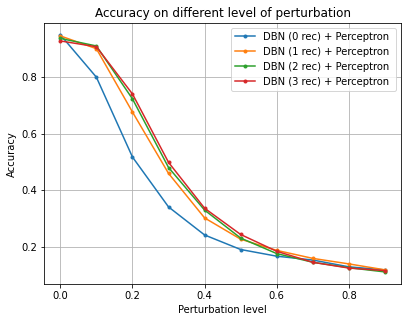

In [46]:
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['dbn_perceptron_0'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['dbn_perceptron_1'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['dbn_perceptron_2'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['dbn_perceptron_3'],
  marker = 'o',
  markersize = 3
)

plt.title(f'Accuracy on different level of perturbation')
plt.ylabel('Accuracy')
plt.xlabel('Perturbation level')
plt.grid()
plt.legend(['DBN (0 rec) + Perceptron ','DBN (1 rec) + Perceptron ','DBN (2 rec) + Perceptron ','DBN (3 rec) + Perceptron ', ], loc='best')
plt.show()

Let's now see the AE+DBN+Perc with different reconstructions (for DBN)

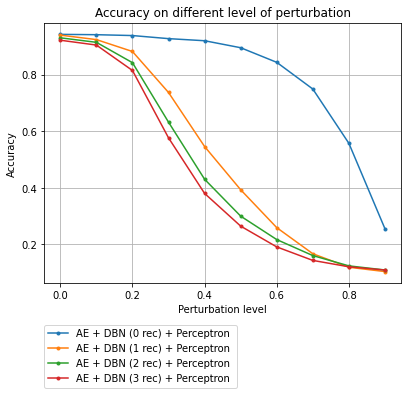

In [47]:
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_dbn_perceptron_0'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_dbn_perceptron_1'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_dbn_perceptron_2'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_dbn_perceptron_3'],
  marker = 'o',
  markersize = 3
)

plt.title(f'Accuracy on different level of perturbation')
plt.ylabel('Accuracy')
plt.xlabel('Perturbation level')
plt.grid()
plt.legend(['AE + DBN (0 rec) + Perceptron ','AE + DBN (1 rec) + Perceptron ','AE + DBN (2 rec) + Perceptron ','AE + DBN (3 rec) + Perceptron ', ],  loc=(0,-0.4))
plt.show()

And now let's change the AE number of reconstructions (we won't change the DBN since we have seen that it just makes thing worse)

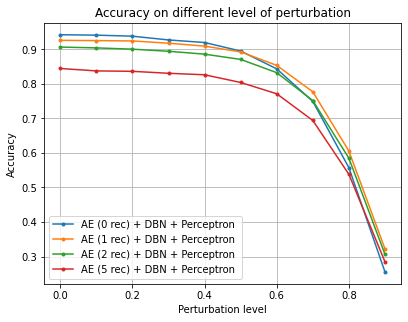

In [48]:
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_0_dbn_perceptron'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_1_dbn_perceptron'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_2_dbn_perceptron'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_5_dbn_perceptron'],
  marker = 'o',
  markersize = 3
)

plt.title(f'Accuracy on different level of perturbation')
plt.ylabel('Accuracy')
plt.xlabel('Perturbation level')
plt.grid()
plt.legend(['AE (0 rec) + DBN + Perceptron ','AE (1 rec) + DBN + Perceptron ','AE (2 rec) + DBN + Perceptron ','AE (5 rec) + DBN + Perceptron ', ], loc='best')
plt.show()

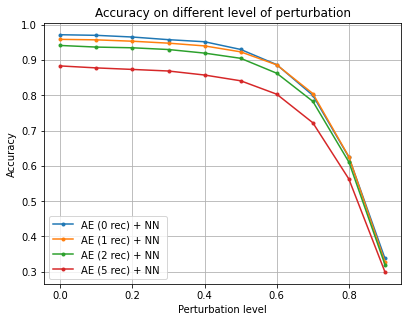

In [49]:
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_0_nn'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_1_nn'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_2_nn'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_5_nn'],
  marker = 'o',
  markersize = 3
)

plt.title(f'Accuracy on different level of perturbation')
plt.ylabel('Accuracy')
plt.xlabel('Perturbation level')
plt.grid()
plt.legend(['AE (0 rec) + NN ','AE (1 rec) + NN ','AE (2 rec) + NN ','AE (5 rec) + NN ', ], loc='best')
plt.show()

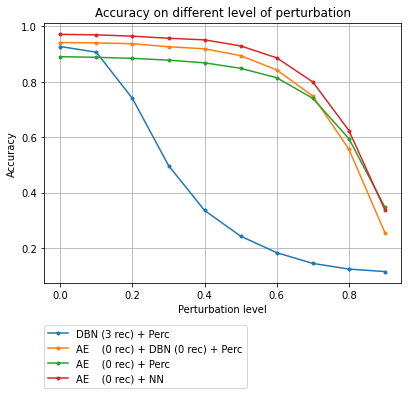

In [50]:

plt.plot(
  np.linspace(0,0.9,10),
  accuracies['dbn_perceptron_3'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_0_dbn_perceptron'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_perceptron'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_0_nn'],
  marker = 'o',
  markersize = 3
)

plt.title(f'Accuracy on different level of perturbation')
plt.ylabel('Accuracy')
plt.xlabel('Perturbation level')
plt.grid()
plt.legend(['DBN (3 rec) + Perc', 'AE    (0 rec) + DBN (0 rec) + Perc', 'AE    (0 rec) + Perc', 'AE    (0 rec) + NN'], loc=(0,-0.4))
plt.show()

We see that the autoencoder clearly makes an amazing job, but we can also see that given a reconstructed image using the autoencoder, the DBN (2 layers of 500 units) it's almost as powerful as a fully connected neural network, with the advantage of the speed that it has in both training and predicting

### Errors evaluation

Let's see what our model is actually missclassifying (we will consider noise at `0.5`)

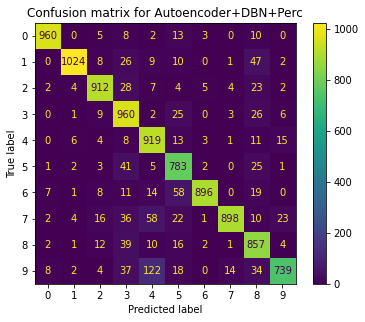

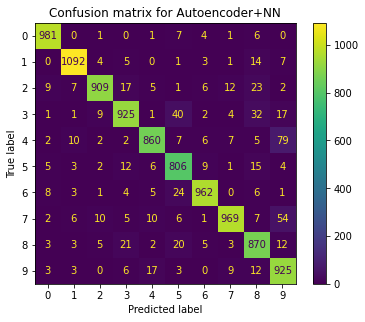

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json


def mat1():
  noisy_test_data = _inject_noise(mnist_data_test, 0.5)
  pred_ae_dbn_perc = pred_Autoencoder_DBN_Perceptron(noisy_test_data)
  cm = confusion_matrix(mnist_targets_test.numpy(), pred_ae_dbn_perc)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title(f'Confusion matrix for Autoencoder+DBN+Perc')
  plt.show()

def mat2():
  noisy_test_data = _inject_noise(mnist_data_test, 0.5)
  pred_ae_nn = pred_Autoencoder_NN(noisy_test_data)
  cm = confusion_matrix(mnist_targets_test.numpy(), pred_ae_nn)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title(f'Confusion matrix for Autoencoder+NN')
  plt.show()

mat1()
mat2()

For both of them, the biggest problem is the discrimination between $4$ and $9$, infact:
 - for AE+DBN+Perc a lot of $9$ were predicted as $4$
 - for AE+NN a lot of $4$ were predicted as 9

To undestarnd why, let's check some errors made by the models.

Starting from the AE+DBN+Perc:

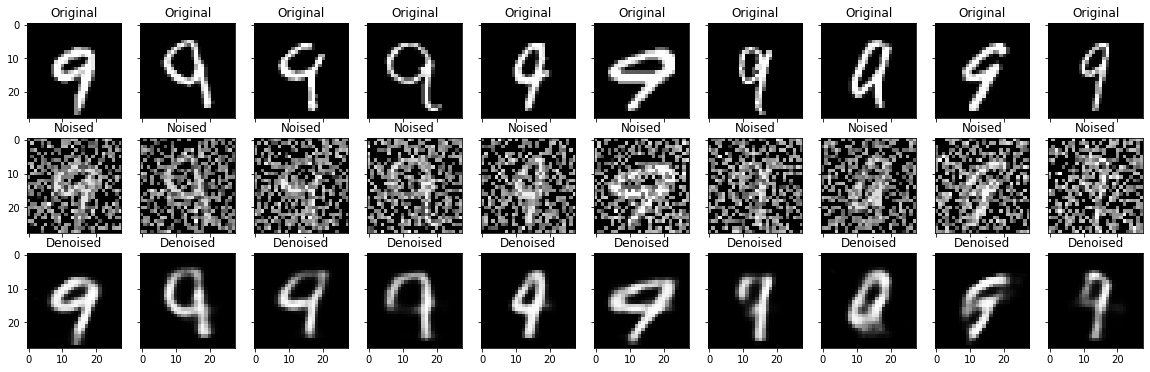

In [52]:
def free():
  noisy_test_data = _inject_noise(mnist_data_test, 0.5)

  #fetch data
  nines = mnist_data_test[
      np.intersect1d(
        np.where(mnist_targets_test == 9)[0], 
        np.where(pred_Autoencoder_DBN_Perceptron(_inject_noise(mnist_data_test, 0.5)) == 4))
      [0:10]]
  nines = nines.reshape((len(nines), 784))


  #inject noise
  nines_noised = _inject_noise(nines,0.5)
  nines_noised = nines_noised.reshape((len(nines_noised), 784))

  #denoise
  nines_denoised = autoencoder_deep_noised_augmented.predict(nines_noised.numpy())


  all = np.concatenate((nines, nines_noised, nines_denoised))

  num_subplots = 30
  n_rows_cols = 10
  fig, axes = plt.subplots(3, 10, sharex=True, sharey=True, figsize=(20, 6))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    if col in [0,3]:
      axes[col, row].title.set_text("Original")
    if col in [1,4]:
      axes[col, row].title.set_text("Noised")
    if col in [2,5]:
      axes[col, row].title.set_text("Denoised")
    axes[col, row].imshow(all[i].reshape((28,28)), cmap=plt.cm.gray)

free()

Those are digits 9 that are being predicted from the AE+DBN+Perc as 4 (which is the highest entry in the confusion matrix).  
What's most likely happening is that there are no more "clear traits" in some areas on the images after the denoising, and so probably, since the number 4 is a "more elastic" 9, not all features of those 9s are being captured by the DBN, and so being exchanged by the perceptron as a 4 (and so it's like "taking out" some pieces from the 9, which probably becomes something like a 4)

Let's now do the same for the NN:

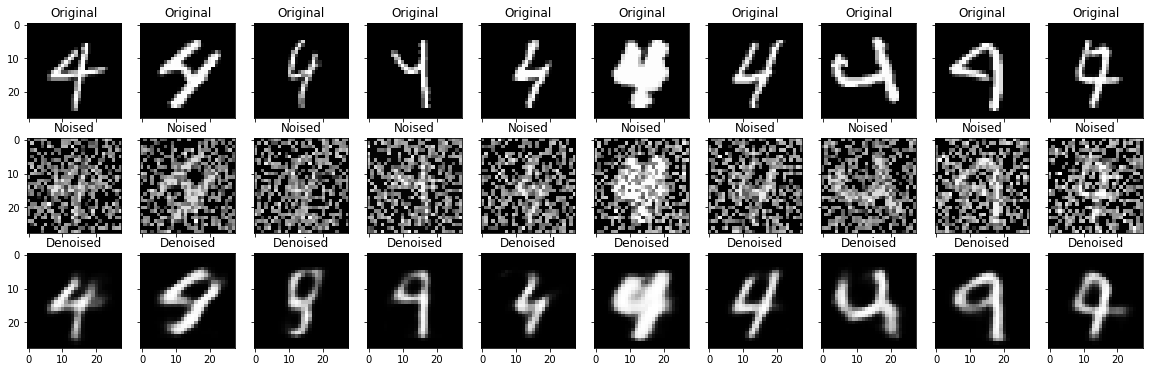

In [53]:
def free():
  noisy_test_data = _inject_noise(mnist_data_test, 0.5)

  #fetch data
  fours = mnist_data_test[
      np.intersect1d(
        np.where(mnist_targets_test == 4)[0], 
        np.where(pred_Autoencoder_NN(_inject_noise(mnist_data_test, 0.5)) == 9))
      [0:10]]
  fours = fours.reshape((len(fours), 784))


  #inject noise
  fours_noised = _inject_noise(fours,0.5)
  fours_noised = fours_noised.reshape((len(fours_noised), 784))

  #denoise
  fours_denoised = autoencoder_deep_noised_augmented.predict(fours_noised.numpy())

  all = np.concatenate((fours, fours_noised, fours_denoised))

  num_subplots = 30
  n_rows_cols = 10
  fig, axes = plt.subplots(3, 10, sharex=True, sharey=True, figsize=(20, 6))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    if col in [0,3]:
      axes[col, row].title.set_text("Original")
    if col in [1,4]:
      axes[col, row].title.set_text("Noised")
    if col in [2,5]:
      axes[col, row].title.set_text("Denoised")
    axes[col, row].imshow(all[i].reshape((28,28)), cmap=plt.cm.gray)

free()

I would say that the reason why the NN is evaluating those as 9 and not as 4; since the beginning the digits were pretty similar to a 9, but the autoencoder, trying to denoise the images, has transformed them to a 9. This is probably due to the layer between the encoder and the decoder, which will map those samples way more close to the average latent space of the number 9 than to the number 4.  
This can also be seen by the fact that if we have a very thin digit since the beginning, and we add some noise over that, the noise might fill some gaps, and so the noise become part of the "thin digit" itself, and can no more be disciminized by the autoencoder.  
In addition to this, there is the fact that the big difference between the 4 and the 9, are the acute angles, and the encoder produce more "opaque" images, removing that acuteness.

All of this contributes to the missclassification (but I would argue that some of those noised images might be even recognized by humans with higher precision that those models have)